<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)

import tqdm
from tqdm import tqdm_notebook

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [5]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

C:\Users\Alexandr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.67956914653526068

In [7]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', index_label='id', header=True)

C:\Users\Alexandr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

In [10]:
def mean_target_enc(train_df, y_train, valid_df, skf, yname='y'):
    import warnings
    warnings.filterwarnings('ignore')
    
    glob_mean = y_train.mean()
    print(len(train_df), len(pd.Series(y_train, name=yname)))
    display(train_df.head())
    train_df = pd.concat([train_df.reset_index(drop=True), pd.Series(y_train, name=yname)], axis=1)
    print(len(train_df), len(y_train))
    new_train_df = train_df.copy()
    
    cat_features = train_df.columns[train_df.dtypes == 'object'].tolist()    

    for col in cat_features:
        new_train_df[col + '_mean_target'] = [glob_mean for _ in range(new_train_df.shape[0])]

    print(len(train_df), len(y_train))
        
    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)[yname].mean())
            valid_df_cv[col + '_mean_target'] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(cat_features + [yname], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)[yname].mean())
        valid_df[col + '_mean_target'] = means.fillna(glob_mean)
        
    valid_df.drop(train_df.columns[train_df.dtypes == 'object'], axis=1, inplace=True)
    
    return new_train_df, valid_df

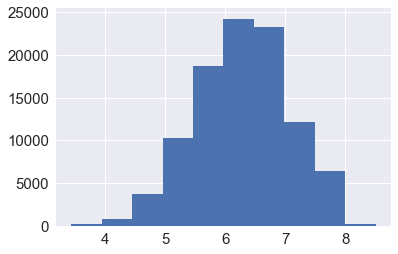

In [11]:
np.log1p(train['Distance']).hist();

In [12]:
def make_features(df, yname='y', ngr=2):
    df['MonthInt'] = df['Month'].apply(lambda x: int(x[2:]))
    df['DayofMonthInt'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
    df['DayOfWeekInt'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))
    
    df['DepHour'] = df['DepTime'] // 100
    df['DepMin'] = df['DepTime'] % 100
    df['isWeekend'] = (df['DayOfWeekInt'] >= 6).astype(int)
    df['DistanceLog'] = np.log1p(df['Distance'])
    df['DistanceLogCat'] = (df['DistanceLog'] > 6).astype(int)
    df['DistanceLogCat1'] = df['DistanceLog'].astype(int)
    
    df['DistanceLogCatStr'] = df['DistanceLogCat'].astype(str)
    df['DistanceLogCat1Str'] = df['DistanceLogCat1'].astype(str)
    df['DepHourStr'] = df['DepHour'].astype(str)
    df['DepMinStr'] = df['DepMin'].astype(str) 
    df['isWeekendStr'] = df['isWeekend'].astype(str) 
    
    cat_features = [e for e in df.columns[df.dtypes == 'object'] if e != yname]
    print(len(cat_features))
    if ngr > 1:
        for i, col1 in enumerate(cat_features):
            for j, col2 in enumerate(cat_features[i + 1:]):
                df[col1 + '_' + col2] = df[col1] + '_' + df[col2]
                if ngr == 3:
                    for k, col3 in enumerate(cat_features[j + 1:]):
                        df[col1 + '_' + col2 + '_' + col3] = df[col1] + '_' + df[col2] + '_' + df[col3]
    return df

In [13]:
train_enrich = make_features(train.copy(), yname='dep_delayed_15min', ngr=3)

11


In [14]:
len(train_enrich.columns)

463

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [16]:
train_df, y = train_enrich.drop('dep_delayed_15min', axis=1).copy(),\
              train_enrich['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df, y, 
                                                                  test_size=.3, stratify=y, 
                                                                               random_state=17)
#train_df_part, valid_df, y_train_part, y_valid = train_test_split(train_df, y, test_size=.3, random_state=17, shuffle=False)

In [17]:
train_mean_target_part, valid_mean_target = mean_target_enc(train_df_part, y_train_part, valid_df, skf, 
                                                            yname='dep_delayed_15min')

70000 70000


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,MonthInt,DayofMonthInt,...,DepMinStr_isWeekendStr_DayofMonth,DepMinStr_isWeekendStr_DayOfWeek,DepMinStr_isWeekendStr_UniqueCarrier,DepMinStr_isWeekendStr_Origin,DepMinStr_isWeekendStr_Dest,DepMinStr_isWeekendStr_DistanceLogCatStr,DepMinStr_isWeekendStr_DistanceLogCat1Str,DepMinStr_isWeekendStr_DepHourStr,DepMinStr_isWeekendStr_DepMinStr,DepMinStr_isWeekendStr_isWeekendStr
88431,c-12,c-19,c-1,622,DH,PWM,IAD,494,12,19,...,22_0_c-19,22_0_c-1,22_0_DH,22_0_PWM,22_0_IAD,22_0_1,22_0_6,22_0_6,22_0_22,22_0_0
83063,c-8,c-4,c-5,904,AS,SNA,PDX,859,8,4,...,4_0_c-4,4_0_c-5,4_0_AS,4_0_SNA,4_0_PDX,4_0_1,4_0_6,4_0_9,4_0_4,4_0_0
1184,c-4,c-3,c-1,605,YV,JFK,IAD,228,4,3,...,5_0_c-3,5_0_c-1,5_0_YV,5_0_JFK,5_0_IAD,5_0_0,5_0_5,5_0_6,5_0_5,5_0_0
78031,c-8,c-6,c-6,658,XE,CHS,EWR,628,8,6,...,58_1_c-6,58_1_c-6,58_1_XE,58_1_CHS,58_1_EWR,58_1_1,58_1_6,58_1_6,58_1_58,58_1_1
4552,c-10,c-9,c-7,1114,MQ,BMI,ORD,116,10,9,...,14_1_c-9,14_1_c-7,14_1_MQ,14_1_BMI,14_1_ORD,14_1_0,14_1_4,14_1_11,14_1_14,14_1_1


70000 70000
70000 70000


In [18]:
logit = LogisticRegression(random_state=17, C=0.01)
scaler = StandardScaler()
logit_pipeline = Pipeline(steps=[('scaler', scaler), ('logit', logit)])

In [19]:
np.mean(cross_val_score(logit_pipeline, train_mean_target_part, y_train_part, cv=skf, scoring='roc_auc'))

0.75708232427968325

In [37]:
logit = LogisticRegression(random_state=17, C=0.01)
scaler = StandardScaler()

scaler.fit(train_mean_target_part)
train_mean_target_part_scaled = scaler.transform(train_mean_target_part)
valid_mean_target_scaled = scaler.transform(valid_mean_target)

logit.fit(train_mean_target_part_scaled, y_train_part)

roc_auc_score(y_valid, logit.predict_proba(valid_mean_target_scaled)[:, 1])

0.77098111372831357

In [107]:
dtrain = xgb.DMatrix(train_mean_target_part, y_train_part)
dtest = xgb.DMatrix(valid_mean_target, y_valid)

params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'silent':1,
    'eta':0.015,
    'eval_metric': 'auc',
    'colsample_bylevel': 0.3,
    'min_child_weight': 20,
    'alpha': 5,
    'subsample': 0.95
}

num_rounds = 1000

watchlist  = [(dtest,'test'), (dtrain,'train')]
evals_result = {}
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist, evals_result=evals_result)

[0]	test-auc:0.741054	train-auc:0.733149
[1]	test-auc:0.750245	train-auc:0.742163
[2]	test-auc:0.755639	train-auc:0.747095
[3]	test-auc:0.755232	train-auc:0.746953
[4]	test-auc:0.756342	train-auc:0.747861
[5]	test-auc:0.757642	train-auc:0.749476
[6]	test-auc:0.758645	train-auc:0.750746
[7]	test-auc:0.75841	train-auc:0.750517
[8]	test-auc:0.759506	train-auc:0.751948
[9]	test-auc:0.758887	train-auc:0.751258
[10]	test-auc:0.759514	train-auc:0.752144
[11]	test-auc:0.760777	train-auc:0.753373
[12]	test-auc:0.761023	train-auc:0.753695
[13]	test-auc:0.761609	train-auc:0.754178
[14]	test-auc:0.761452	train-auc:0.754243
[15]	test-auc:0.761396	train-auc:0.75398
[16]	test-auc:0.761371	train-auc:0.753845
[17]	test-auc:0.761412	train-auc:0.754082
[18]	test-auc:0.761726	train-auc:0.754532
[19]	test-auc:0.762055	train-auc:0.754867
[20]	test-auc:0.762118	train-auc:0.755002
[21]	test-auc:0.762378	train-auc:0.755297
[22]	test-auc:0.762404	train-auc:0.755416
[23]	test-auc:0.762444	train-auc:0.755602
[24]

[194]	test-auc:0.779083	train-auc:0.776347
[195]	test-auc:0.779115	train-auc:0.776433
[196]	test-auc:0.779204	train-auc:0.776584
[197]	test-auc:0.779282	train-auc:0.776689
[198]	test-auc:0.779352	train-auc:0.776786
[199]	test-auc:0.779416	train-auc:0.776892
[200]	test-auc:0.779468	train-auc:0.776964
[201]	test-auc:0.779521	train-auc:0.777057
[202]	test-auc:0.779612	train-auc:0.777172
[203]	test-auc:0.779682	train-auc:0.777257
[204]	test-auc:0.779792	train-auc:0.777388
[205]	test-auc:0.779929	train-auc:0.777538
[206]	test-auc:0.780051	train-auc:0.777668
[207]	test-auc:0.780094	train-auc:0.777768
[208]	test-auc:0.780113	train-auc:0.777837
[209]	test-auc:0.780152	train-auc:0.777924
[210]	test-auc:0.780198	train-auc:0.778005
[211]	test-auc:0.780265	train-auc:0.778092
[212]	test-auc:0.780299	train-auc:0.778183
[213]	test-auc:0.780335	train-auc:0.778289
[214]	test-auc:0.780407	train-auc:0.778374
[215]	test-auc:0.780512	train-auc:0.778519
[216]	test-auc:0.780547	train-auc:0.778584
[217]	test-

[386]	test-auc:0.78712	train-auc:0.791669
[387]	test-auc:0.787143	train-auc:0.791729
[388]	test-auc:0.787221	train-auc:0.791838
[389]	test-auc:0.787224	train-auc:0.791873
[390]	test-auc:0.787225	train-auc:0.791907
[391]	test-auc:0.787236	train-auc:0.791975
[392]	test-auc:0.787243	train-auc:0.792027
[393]	test-auc:0.787264	train-auc:0.792077
[394]	test-auc:0.78728	train-auc:0.792115
[395]	test-auc:0.787297	train-auc:0.792183
[396]	test-auc:0.787324	train-auc:0.792237
[397]	test-auc:0.787366	train-auc:0.792301
[398]	test-auc:0.787369	train-auc:0.792347
[399]	test-auc:0.7874	train-auc:0.79241
[400]	test-auc:0.787423	train-auc:0.792465
[401]	test-auc:0.78746	train-auc:0.792517
[402]	test-auc:0.787473	train-auc:0.79256
[403]	test-auc:0.78752	train-auc:0.792633
[404]	test-auc:0.787537	train-auc:0.792688
[405]	test-auc:0.787544	train-auc:0.792724
[406]	test-auc:0.787552	train-auc:0.792787
[407]	test-auc:0.787542	train-auc:0.792814
[408]	test-auc:0.787552	train-auc:0.792864
[409]	test-auc:0.78

[578]	test-auc:0.789663	train-auc:0.800886
[579]	test-auc:0.789673	train-auc:0.800921
[580]	test-auc:0.789679	train-auc:0.800966
[581]	test-auc:0.78969	train-auc:0.801014
[582]	test-auc:0.789697	train-auc:0.801037
[583]	test-auc:0.789695	train-auc:0.801091
[584]	test-auc:0.789707	train-auc:0.801145
[585]	test-auc:0.789701	train-auc:0.801196
[586]	test-auc:0.789723	train-auc:0.801263
[587]	test-auc:0.789735	train-auc:0.801294
[588]	test-auc:0.789772	train-auc:0.801352
[589]	test-auc:0.789768	train-auc:0.801402
[590]	test-auc:0.789772	train-auc:0.801441
[591]	test-auc:0.789778	train-auc:0.801471
[592]	test-auc:0.789774	train-auc:0.801518
[593]	test-auc:0.789782	train-auc:0.801573
[594]	test-auc:0.789785	train-auc:0.801597
[595]	test-auc:0.789781	train-auc:0.801625
[596]	test-auc:0.789775	train-auc:0.801673
[597]	test-auc:0.78977	train-auc:0.801707
[598]	test-auc:0.78977	train-auc:0.801748
[599]	test-auc:0.789779	train-auc:0.801778
[600]	test-auc:0.789789	train-auc:0.801821
[601]	test-auc

[770]	test-auc:0.790715	train-auc:0.809139
[771]	test-auc:0.790699	train-auc:0.809183
[772]	test-auc:0.79069	train-auc:0.809213
[773]	test-auc:0.79069	train-auc:0.809231
[774]	test-auc:0.790679	train-auc:0.809288
[775]	test-auc:0.790683	train-auc:0.809336
[776]	test-auc:0.790704	train-auc:0.80939
[777]	test-auc:0.790728	train-auc:0.809443
[778]	test-auc:0.790766	train-auc:0.809491
[779]	test-auc:0.790773	train-auc:0.809526
[780]	test-auc:0.79077	train-auc:0.809552
[781]	test-auc:0.790766	train-auc:0.809597
[782]	test-auc:0.790769	train-auc:0.809619
[783]	test-auc:0.790763	train-auc:0.809672
[784]	test-auc:0.790762	train-auc:0.809733
[785]	test-auc:0.790771	train-auc:0.809777
[786]	test-auc:0.790771	train-auc:0.809819
[787]	test-auc:0.790772	train-auc:0.809859
[788]	test-auc:0.790778	train-auc:0.809884
[789]	test-auc:0.790788	train-auc:0.809924
[790]	test-auc:0.790787	train-auc:0.809965
[791]	test-auc:0.790789	train-auc:0.809982
[792]	test-auc:0.79079	train-auc:0.810047
[793]	test-auc:0

[962]	test-auc:0.791184	train-auc:0.816449
[963]	test-auc:0.791195	train-auc:0.816489
[964]	test-auc:0.791256	train-auc:0.816561
[965]	test-auc:0.791256	train-auc:0.816613
[966]	test-auc:0.791252	train-auc:0.816649
[967]	test-auc:0.791256	train-auc:0.816702
[968]	test-auc:0.791244	train-auc:0.816723
[969]	test-auc:0.791242	train-auc:0.81674
[970]	test-auc:0.79124	train-auc:0.816787
[971]	test-auc:0.791248	train-auc:0.81682
[972]	test-auc:0.791242	train-auc:0.816841
[973]	test-auc:0.791236	train-auc:0.816885
[974]	test-auc:0.791236	train-auc:0.816919
[975]	test-auc:0.791275	train-auc:0.816975
[976]	test-auc:0.791292	train-auc:0.81702
[977]	test-auc:0.791299	train-auc:0.817067
[978]	test-auc:0.791295	train-auc:0.8171
[979]	test-auc:0.791299	train-auc:0.817124
[980]	test-auc:0.791303	train-auc:0.817163
[981]	test-auc:0.791302	train-auc:0.817178
[982]	test-auc:0.791305	train-auc:0.817213
[983]	test-auc:0.791309	train-auc:0.817239
[984]	test-auc:0.791312	train-auc:0.817255
[985]	test-auc:0.

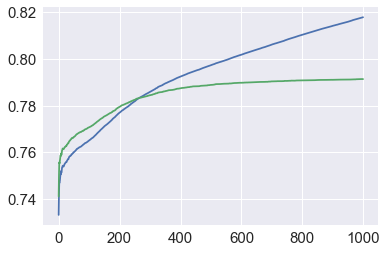

In [109]:
plt.plot(evals_result['train']['auc'])
plt.plot(evals_result['test']['auc'])

In [71]:
train_mean_target_part.head()

,DepTime,Distance,MonthInt,DayofMonthInt,DayOfWeekInt,DepHour,DepMin,isWeekend,DistanceLog,DistanceLogCat,...,DepMinStr_isWeekendStr_DayofMonth_mean_target,DepMinStr_isWeekendStr_DayOfWeek_mean_target,DepMinStr_isWeekendStr_UniqueCarrier_mean_target,DepMinStr_isWeekendStr_Origin_mean_target,DepMinStr_isWeekendStr_Dest_mean_target,DepMinStr_isWeekendStr_DistanceLogCatStr_mean_target,DepMinStr_isWeekendStr_DistanceLogCat1Str_mean_target,DepMinStr_isWeekendStr_DepHourStr_mean_target,DepMinStr_isWeekendStr_DepMinStr_mean_target,DepMinStr_isWeekendStr_isWeekendStr_mean_target
0,622,494,12,19,1,6,22,0,6.204558,1,...,0.333333,0.239316,0.333333,1.000000,0.500,0.241379,0.250000,0.000000,0.230366,0.230366
1,904,859,8,4,5,9,4,0,6.756932,1,...,0.095238,0.254386,0.357143,0.000000,0.000,0.185567,0.197080,0.153846,0.189239,0.189239
2,605,228,4,3,1,6,5,0,5.433722,0,...,0.214286,0.211640,0.151515,0.411765,0.125,0.164619,0.164865,0.000000,0.188353,0.188353
3,658,628,8,6,6,6,58,1,6.444131,1,...,0.100000,0.103448,0.157895,0.000000,0.100,0.148352,0.172932,0.000000,0.152263,0.152263
4,1114,116,10,9,7,11,14,1,4.762174,0,...,0.000000,0.186916,0.117647,0.190443,0.200,0.254237,0.500000,0.266667,0.195000,0.195000


In [59]:
import catboost

In [83]:
cat_model = catboost.CatBoostClassifier(iterations=1000, depth=5, learning_rate=0.03, 
                                        loss_function='Logloss', eval_metric='AUC',
                                        l2_leaf_reg=30, rsm=0.3,
                                        verbose=True)
#train the model
cat_model.fit(train_mean_target_part, y_train_part, cat_features=[2,3,4,5,6], verbose=True,
             eval_set=(valid_mean_target, y_valid))

0: learn: 0.688184	test: 0.6971948	bestTest: 0.6971948 (0)	total: 173ms	remaining: 2m 52s
1: learn: 0.7118685	test: 0.7246438	bestTest: 0.7246438 (1)	total: 347ms	remaining: 2m 53s
2: learn: 0.7171766	test: 0.7304418	bestTest: 0.7304418 (2)	total: 529ms	remaining: 2m 55s
3: learn: 0.729403	test: 0.743656	bestTest: 0.743656 (3)	total: 703ms	remaining: 2m 55s
4: learn: 0.7275753	test: 0.7415106	bestTest: 0.743656 (3)	total: 894ms	remaining: 2m 57s
5: learn: 0.7253393	test: 0.738895	bestTest: 0.743656 (3)	total: 1.07s	remaining: 2m 58s
6: learn: 0.7288835	test: 0.7421332	bestTest: 0.743656 (3)	total: 1.25s	remaining: 2m 57s
7: learn: 0.7326524	test: 0.7452864	bestTest: 0.7452864 (7)	total: 1.42s	remaining: 2m 56s
8: learn: 0.7341962	test: 0.7467829	bestTest: 0.7467829 (8)	total: 1.61s	remaining: 2m 57s
9: learn: 0.736818	test: 0.7497071	bestTest: 0.7497071 (9)	total: 1.79s	remaining: 2m 57s
10: learn: 0.7394911	test: 0.7520803	bestTest: 0.7520803 (10)	total: 1.97s	remaining: 2m 57s
11: le

89: learn: 0.7631563	test: 0.7752303	bestTest: 0.7752303 (89)	total: 16.6s	remaining: 2m 48s
90: learn: 0.7632928	test: 0.7753334	bestTest: 0.7753334 (90)	total: 16.8s	remaining: 2m 48s
91: learn: 0.7634532	test: 0.7754283	bestTest: 0.7754283 (91)	total: 17s	remaining: 2m 48s
92: learn: 0.7636516	test: 0.7755521	bestTest: 0.7755521 (92)	total: 17.2s	remaining: 2m 48s
93: learn: 0.7638017	test: 0.7756684	bestTest: 0.7756684 (93)	total: 17.5s	remaining: 2m 48s
94: learn: 0.763919	test: 0.7757261	bestTest: 0.7757261 (94)	total: 17.7s	remaining: 2m 48s
95: learn: 0.764039	test: 0.7758202	bestTest: 0.7758202 (95)	total: 17.9s	remaining: 2m 48s
96: learn: 0.7640821	test: 0.7758396	bestTest: 0.7758396 (96)	total: 18.1s	remaining: 2m 48s
97: learn: 0.7642912	test: 0.7759917	bestTest: 0.7759917 (97)	total: 18.3s	remaining: 2m 48s
98: learn: 0.7643903	test: 0.7760267	bestTest: 0.7760267 (98)	total: 18.4s	remaining: 2m 47s
99: learn: 0.7646076	test: 0.7761214	bestTest: 0.7761214 (99)	total: 18.6s

176: learn: 0.771671	test: 0.7812093	bestTest: 0.7812093 (176)	total: 34.2s	remaining: 2m 38s
177: learn: 0.7717513	test: 0.781245	bestTest: 0.781245 (177)	total: 34.4s	remaining: 2m 38s
178: learn: 0.771814	test: 0.7812831	bestTest: 0.7812831 (178)	total: 34.6s	remaining: 2m 38s
179: learn: 0.7718634	test: 0.7813075	bestTest: 0.7813075 (179)	total: 34.8s	remaining: 2m 38s
180: learn: 0.7719361	test: 0.7813969	bestTest: 0.7813969 (180)	total: 35s	remaining: 2m 38s
181: learn: 0.7720596	test: 0.7815735	bestTest: 0.7815735 (181)	total: 35.2s	remaining: 2m 38s
182: learn: 0.7721307	test: 0.7816134	bestTest: 0.7816134 (182)	total: 35.4s	remaining: 2m 37s
183: learn: 0.772196	test: 0.7816305	bestTest: 0.7816305 (183)	total: 35.6s	remaining: 2m 37s
184: learn: 0.7722675	test: 0.781658	bestTest: 0.781658 (184)	total: 35.8s	remaining: 2m 37s
185: learn: 0.7723012	test: 0.7816691	bestTest: 0.7816691 (185)	total: 36s	remaining: 2m 37s
186: learn: 0.7723787	test: 0.7816636	bestTest: 0.7816691 (18

263: learn: 0.7770789	test: 0.7845616	bestTest: 0.7845616 (263)	total: 51.7s	remaining: 2m 24s
264: learn: 0.777122	test: 0.7845587	bestTest: 0.7845616 (263)	total: 51.9s	remaining: 2m 23s
265: learn: 0.7772062	test: 0.7846251	bestTest: 0.7846251 (265)	total: 52.1s	remaining: 2m 23s
266: learn: 0.7772433	test: 0.7846349	bestTest: 0.7846349 (266)	total: 52.3s	remaining: 2m 23s
267: learn: 0.777295	test: 0.7846474	bestTest: 0.7846474 (267)	total: 52.5s	remaining: 2m 23s
268: learn: 0.7773236	test: 0.7846511	bestTest: 0.7846511 (268)	total: 52.7s	remaining: 2m 23s
269: learn: 0.7773635	test: 0.7846513	bestTest: 0.7846513 (269)	total: 52.9s	remaining: 2m 22s
270: learn: 0.7774265	test: 0.7846611	bestTest: 0.7846611 (270)	total: 53.1s	remaining: 2m 22s
271: learn: 0.777487	test: 0.7846906	bestTest: 0.7846906 (271)	total: 53.3s	remaining: 2m 22s
272: learn: 0.7775356	test: 0.7846994	bestTest: 0.7846994 (272)	total: 53.5s	remaining: 2m 22s
273: learn: 0.7776319	test: 0.7847602	bestTest: 0.784

350: learn: 0.7811783	test: 0.7859374	bestTest: 0.7859374 (350)	total: 1m 9s	remaining: 2m 8s
351: learn: 0.7812297	test: 0.7859616	bestTest: 0.7859616 (351)	total: 1m 9s	remaining: 2m 8s
352: learn: 0.7812636	test: 0.7859734	bestTest: 0.7859734 (352)	total: 1m 9s	remaining: 2m 7s
353: learn: 0.7812937	test: 0.7859898	bestTest: 0.7859898 (353)	total: 1m 9s	remaining: 2m 7s
354: learn: 0.7813328	test: 0.7859877	bestTest: 0.7859898 (353)	total: 1m 10s	remaining: 2m 7s
355: learn: 0.7813783	test: 0.7859875	bestTest: 0.7859898 (353)	total: 1m 10s	remaining: 2m 7s
356: learn: 0.7814369	test: 0.7860547	bestTest: 0.7860547 (356)	total: 1m 10s	remaining: 2m 6s
357: learn: 0.7814896	test: 0.7860637	bestTest: 0.7860637 (357)	total: 1m 10s	remaining: 2m 6s
358: learn: 0.781526	test: 0.7860481	bestTest: 0.7860637 (357)	total: 1m 10s	remaining: 2m 6s
359: learn: 0.7815756	test: 0.7860374	bestTest: 0.7860637 (357)	total: 1m 11s	remaining: 2m 6s
360: learn: 0.7816297	test: 0.7860639	bestTest: 0.78606

436: learn: 0.7852847	test: 0.7871946	bestTest: 0.7871946 (436)	total: 1m 26s	remaining: 1m 51s
437: learn: 0.7853204	test: 0.7871979	bestTest: 0.7871979 (437)	total: 1m 27s	remaining: 1m 51s
438: learn: 0.7853546	test: 0.7871924	bestTest: 0.7871979 (437)	total: 1m 27s	remaining: 1m 51s
439: learn: 0.7853956	test: 0.7872437	bestTest: 0.7872437 (439)	total: 1m 27s	remaining: 1m 51s
440: learn: 0.7854351	test: 0.787247	bestTest: 0.787247 (440)	total: 1m 27s	remaining: 1m 51s
441: learn: 0.785473	test: 0.7872541	bestTest: 0.7872541 (441)	total: 1m 27s	remaining: 1m 50s
442: learn: 0.7855187	test: 0.7872459	bestTest: 0.7872541 (441)	total: 1m 28s	remaining: 1m 50s
443: learn: 0.7855773	test: 0.7872633	bestTest: 0.7872633 (443)	total: 1m 28s	remaining: 1m 50s
444: learn: 0.785638	test: 0.7873305	bestTest: 0.7873305 (444)	total: 1m 28s	remaining: 1m 50s
445: learn: 0.7856968	test: 0.7873351	bestTest: 0.7873351 (445)	total: 1m 28s	remaining: 1m 50s
446: learn: 0.7857542	test: 0.7873559	bestTe

522: learn: 0.7891826	test: 0.7879733	bestTest: 0.7879869 (521)	total: 1m 44s	remaining: 1m 35s
523: learn: 0.7892332	test: 0.7879801	bestTest: 0.7879869 (521)	total: 1m 44s	remaining: 1m 34s
524: learn: 0.7892682	test: 0.7879858	bestTest: 0.7879869 (521)	total: 1m 44s	remaining: 1m 34s
525: learn: 0.7892929	test: 0.7879949	bestTest: 0.7879949 (525)	total: 1m 44s	remaining: 1m 34s
526: learn: 0.7893387	test: 0.7880157	bestTest: 0.7880157 (526)	total: 1m 45s	remaining: 1m 34s
527: learn: 0.7893623	test: 0.788023	bestTest: 0.788023 (527)	total: 1m 45s	remaining: 1m 34s
528: learn: 0.7894106	test: 0.7880557	bestTest: 0.7880557 (528)	total: 1m 45s	remaining: 1m 33s
529: learn: 0.7894429	test: 0.7880806	bestTest: 0.7880806 (529)	total: 1m 45s	remaining: 1m 33s
530: learn: 0.7894689	test: 0.7880809	bestTest: 0.7880809 (530)	total: 1m 45s	remaining: 1m 33s
531: learn: 0.7895069	test: 0.7880685	bestTest: 0.7880809 (530)	total: 1m 46s	remaining: 1m 33s
532: learn: 0.7895489	test: 0.7880768	best

608: learn: 0.7927778	test: 0.7886603	bestTest: 0.7886629 (606)	total: 2m 1s	remaining: 1m 18s
609: learn: 0.7928275	test: 0.7886472	bestTest: 0.7886629 (606)	total: 2m 1s	remaining: 1m 17s
610: learn: 0.7928618	test: 0.7886308	bestTest: 0.7886629 (606)	total: 2m 2s	remaining: 1m 17s
611: learn: 0.7929154	test: 0.788642	bestTest: 0.7886629 (606)	total: 2m 2s	remaining: 1m 17s
612: learn: 0.7929499	test: 0.7886535	bestTest: 0.7886629 (606)	total: 2m 2s	remaining: 1m 17s
613: learn: 0.7929789	test: 0.7886572	bestTest: 0.7886629 (606)	total: 2m 2s	remaining: 1m 17s
614: learn: 0.7929934	test: 0.7886662	bestTest: 0.7886662 (614)	total: 2m 2s	remaining: 1m 16s
615: learn: 0.7930467	test: 0.788662	bestTest: 0.7886662 (614)	total: 2m 3s	remaining: 1m 16s
616: learn: 0.7930753	test: 0.7886689	bestTest: 0.7886689 (616)	total: 2m 3s	remaining: 1m 16s
617: learn: 0.7931332	test: 0.7886707	bestTest: 0.7886707 (617)	total: 2m 3s	remaining: 1m 16s
618: learn: 0.7931684	test: 0.7886786	bestTest: 0.78

694: learn: 0.7961777	test: 0.7890092	bestTest: 0.7890261 (690)	total: 2m 19s	remaining: 1m 1s
695: learn: 0.7961985	test: 0.7889987	bestTest: 0.7890261 (690)	total: 2m 19s	remaining: 1m
696: learn: 0.7962286	test: 0.7889964	bestTest: 0.7890261 (690)	total: 2m 19s	remaining: 1m
697: learn: 0.7962731	test: 0.7890046	bestTest: 0.7890261 (690)	total: 2m 19s	remaining: 1m
698: learn: 0.7963275	test: 0.7890106	bestTest: 0.7890261 (690)	total: 2m 20s	remaining: 1m
699: learn: 0.7963618	test: 0.7890031	bestTest: 0.7890261 (690)	total: 2m 20s	remaining: 1m
700: learn: 0.796386	test: 0.7890038	bestTest: 0.7890261 (690)	total: 2m 20s	remaining: 59.9s
701: learn: 0.7964144	test: 0.7890095	bestTest: 0.7890261 (690)	total: 2m 20s	remaining: 59.7s
702: learn: 0.7964531	test: 0.7890128	bestTest: 0.7890261 (690)	total: 2m 20s	remaining: 59.5s
703: learn: 0.7964843	test: 0.7890265	bestTest: 0.7890265 (703)	total: 2m 21s	remaining: 59.3s
704: learn: 0.7965227	test: 0.7890242	bestTest: 0.7890265 (703)	to

780: learn: 0.7996129	test: 0.7893281	bestTest: 0.7893281 (780)	total: 2m 36s	remaining: 43.9s
781: learn: 0.7996556	test: 0.7893247	bestTest: 0.7893281 (780)	total: 2m 36s	remaining: 43.7s
782: learn: 0.7996885	test: 0.7893244	bestTest: 0.7893281 (780)	total: 2m 37s	remaining: 43.5s
783: learn: 0.7997056	test: 0.789333	bestTest: 0.789333 (783)	total: 2m 37s	remaining: 43.3s
784: learn: 0.7997415	test: 0.7893495	bestTest: 0.7893495 (784)	total: 2m 37s	remaining: 43.1s
785: learn: 0.7997716	test: 0.7893206	bestTest: 0.7893495 (784)	total: 2m 37s	remaining: 42.9s
786: learn: 0.7998045	test: 0.7893292	bestTest: 0.7893495 (784)	total: 2m 37s	remaining: 42.7s
787: learn: 0.7998577	test: 0.7893397	bestTest: 0.7893495 (784)	total: 2m 38s	remaining: 42.5s
788: learn: 0.7998794	test: 0.7893353	bestTest: 0.7893495 (784)	total: 2m 38s	remaining: 42.3s
789: learn: 0.7999133	test: 0.7893318	bestTest: 0.7893495 (784)	total: 2m 38s	remaining: 42.1s
790: learn: 0.799946	test: 0.7893198	bestTest: 0.789

866: learn: 0.8027925	test: 0.7894539	bestTest: 0.7894575 (857)	total: 2m 54s	remaining: 26.7s
867: learn: 0.8028309	test: 0.7894623	bestTest: 0.7894623 (867)	total: 2m 54s	remaining: 26.5s
868: learn: 0.8028719	test: 0.7894607	bestTest: 0.7894623 (867)	total: 2m 54s	remaining: 26.3s
869: learn: 0.8028976	test: 0.7894631	bestTest: 0.7894631 (869)	total: 2m 54s	remaining: 26.1s
870: learn: 0.8029384	test: 0.789462	bestTest: 0.7894631 (869)	total: 2m 55s	remaining: 25.9s
871: learn: 0.8029601	test: 0.7894674	bestTest: 0.7894674 (871)	total: 2m 55s	remaining: 25.7s
872: learn: 0.8030147	test: 0.7894733	bestTest: 0.7894733 (872)	total: 2m 55s	remaining: 25.5s
873: learn: 0.8030442	test: 0.78948	bestTest: 0.78948 (873)	total: 2m 55s	remaining: 25.3s
874: learn: 0.8030838	test: 0.7895099	bestTest: 0.7895099 (874)	total: 2m 55s	remaining: 25.1s
875: learn: 0.8031115	test: 0.7895155	bestTest: 0.7895155 (875)	total: 2m 56s	remaining: 24.9s
876: learn: 0.8031489	test: 0.7895184	bestTest: 0.78951

953: learn: 0.8061083	test: 0.7896645	bestTest: 0.7896804 (951)	total: 3m 11s	remaining: 9.25s
954: learn: 0.8061378	test: 0.7896749	bestTest: 0.7896804 (951)	total: 3m 11s	remaining: 9.05s
955: learn: 0.8061607	test: 0.7896709	bestTest: 0.7896804 (951)	total: 3m 12s	remaining: 8.85s
956: learn: 0.806185	test: 0.7896669	bestTest: 0.7896804 (951)	total: 3m 12s	remaining: 8.64s
957: learn: 0.8062208	test: 0.7896764	bestTest: 0.7896804 (951)	total: 3m 12s	remaining: 8.44s
958: learn: 0.8062707	test: 0.789685	bestTest: 0.789685 (958)	total: 3m 12s	remaining: 8.24s
959: learn: 0.8063164	test: 0.789696	bestTest: 0.789696 (959)	total: 3m 12s	remaining: 8.04s
960: learn: 0.8063376	test: 0.7896833	bestTest: 0.789696 (959)	total: 3m 13s	remaining: 7.84s
961: learn: 0.8063506	test: 0.7896915	bestTest: 0.789696 (959)	total: 3m 13s	remaining: 7.64s
962: learn: 0.8063872	test: 0.7896974	bestTest: 0.7896974 (962)	total: 3m 13s	remaining: 7.44s
963: learn: 0.8064046	test: 0.7896929	bestTest: 0.7896974

In [93]:
cat_pred = cat_model.predict_proba(valid_mean_target)[:, 1]
xgb_pred = xgb_model.predict(dtest)
for w in np.linspace(0, 1, 21):
    print(w, roc_auc_score(y_valid, w * xgb_pred + (1 - w) * cat_pred))

0.0 0.789808885202
0.05 0.790049149044
0.1 0.790271813093
0.15 0.790475897181
0.2 0.790662705796
0.25 0.790838739762
0.3 0.790997548706
0.35 0.791138130838
0.4 0.791259383466
0.45 0.791362848917
0.5 0.791440829982
0.55 0.791510508442
0.6 0.79156877082
0.65 0.791603350594
0.7 0.79162184407
0.75 0.791620352196
0.8 0.791605462281
0.85 0.791574651832
0.9 0.7915230128
0.95 0.791451820844
1.0 0.791362549821


In [55]:
logit_pred = logit.predict_proba(valid_mean_target_scaled)[:, 1]
xgb_pred = xgb_model.predict(dtest)
for w in np.linspace(0.8, 1, 21):
    print(w, roc_auc_score(y_valid, w * xgb_pred + (1 - w) * logit_pred))

0.8 0.78521879141
0.81 0.785515609543
0.82 0.785816478078
0.83 0.786132459949
0.84 0.786455411108
0.85 0.78679027564
0.86 0.787122329394
0.87 0.787466469493
0.88 0.787814768102
0.89 0.788168681059
0.9 0.788529253397
0.91 0.788896391423
0.92 0.789268444708
0.93 0.789628382819
0.94 0.789967571624
0.95 0.790298299268
0.96 0.790590843577
0.97 0.790842840615
0.98 0.791058102949
0.99 0.791204494021
1.0 0.791259415898


In [23]:
test_enrich = make_features(test.copy(), yname='dep_delayed_15min', ngr=3)
test_df = test_enrich.copy()
train_mean_target, test_mean_target = mean_target_enc(train_df, y_train, test_df, skf, yname='dep_delayed_15min')

11
100000 100000


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,MonthInt,DayofMonthInt,...,DepMinStr_isWeekendStr_DayofMonth,DepMinStr_isWeekendStr_DayOfWeek,DepMinStr_isWeekendStr_UniqueCarrier,DepMinStr_isWeekendStr_Origin,DepMinStr_isWeekendStr_Dest,DepMinStr_isWeekendStr_DistanceLogCatStr,DepMinStr_isWeekendStr_DistanceLogCat1Str,DepMinStr_isWeekendStr_DepHourStr,DepMinStr_isWeekendStr_DepMinStr,DepMinStr_isWeekendStr_isWeekendStr
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,...,34_1_c-21,34_1_c-7,34_1_AA,34_1_ATL,34_1_DFW,34_1_1,34_1_6,34_1_19,34_1_34,34_1_1
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,...,48_0_c-20,48_0_c-3,48_0_US,48_0_PIT,48_0_MCO,48_0_1,48_0_6,48_0_15,48_0_48,48_0_0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,...,22_0_c-2,22_0_c-5,22_0_XE,22_0_RDU,22_0_CLE,22_0_1,22_0_6,22_0_14,22_0_22,22_0_0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,...,15_1_c-25,15_1_c-6,15_1_OO,15_1_DEN,15_1_MEM,15_1_1,15_1_6,15_1_10,15_1_15,15_1_1
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,...,28_1_c-7,28_1_c-6,28_1_WN,28_1_MDW,28_1_OMA,28_1_1,28_1_6,28_1_18,28_1_28,28_1_1


100000 100000
100000 100000


In [41]:
logit = LogisticRegression(random_state=17, C=0.01)
scaler = StandardScaler()

In [42]:
scaler.fit(train_mean_target)
train_mean_target_scaled = scaler.transform(train_mean_target)
test_mean_target_scaled = scaler.transform(test_mean_target)

In [43]:
logit.fit(train_mean_target, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
logit_test_pred = logit.predict_proba(test_mean_target_scaled)[:, 1]
pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_my_2.csv', index_label='id', header=True)

In [94]:
dtrain_final = xgb.DMatrix(train_mean_target, y_train)
dtest_final = xgb.DMatrix(test_mean_target)
num_rounds = 1000
watchlist  = [(dtrain_final,'train')]
xgb_model_final = xgb.train(params, dtrain_final, num_rounds, watchlist)

[0]	train-auc:0.733334
[1]	train-auc:0.750051
[2]	train-auc:0.755818
[3]	train-auc:0.758521
[4]	train-auc:0.759072
[5]	train-auc:0.759377
[6]	train-auc:0.761639
[7]	train-auc:0.762356
[8]	train-auc:0.762496
[9]	train-auc:0.763019
[10]	train-auc:0.762859
[11]	train-auc:0.763752
[12]	train-auc:0.764219
[13]	train-auc:0.764626
[14]	train-auc:0.765277
[15]	train-auc:0.765257
[16]	train-auc:0.76506
[17]	train-auc:0.765275
[18]	train-auc:0.7658
[19]	train-auc:0.766032
[20]	train-auc:0.766338
[21]	train-auc:0.766398
[22]	train-auc:0.766474
[23]	train-auc:0.766594
[24]	train-auc:0.76662
[25]	train-auc:0.766801
[26]	train-auc:0.766802
[27]	train-auc:0.766844
[28]	train-auc:0.766948
[29]	train-auc:0.767103
[30]	train-auc:0.767357
[31]	train-auc:0.767316
[32]	train-auc:0.767501
[33]	train-auc:0.76759
[34]	train-auc:0.767658
[35]	train-auc:0.767822
[36]	train-auc:0.76786
[37]	train-auc:0.768058
[38]	train-auc:0.768136
[39]	train-auc:0.768268
[40]	train-auc:0.768347
[41]	train-auc:0.768471
[42]	tra

[334]	train-auc:0.795945
[335]	train-auc:0.795984
[336]	train-auc:0.796043
[337]	train-auc:0.7961
[338]	train-auc:0.796187
[339]	train-auc:0.7963
[340]	train-auc:0.796338
[341]	train-auc:0.796374
[342]	train-auc:0.79643
[343]	train-auc:0.796466
[344]	train-auc:0.796509
[345]	train-auc:0.796556
[346]	train-auc:0.796602
[347]	train-auc:0.796638
[348]	train-auc:0.796688
[349]	train-auc:0.796747
[350]	train-auc:0.796785
[351]	train-auc:0.796843
[352]	train-auc:0.796875
[353]	train-auc:0.796977
[354]	train-auc:0.797022
[355]	train-auc:0.797074
[356]	train-auc:0.797108
[357]	train-auc:0.797152
[358]	train-auc:0.797192
[359]	train-auc:0.79722
[360]	train-auc:0.797254
[361]	train-auc:0.797316
[362]	train-auc:0.797367
[363]	train-auc:0.79742
[364]	train-auc:0.797517
[365]	train-auc:0.797557
[366]	train-auc:0.797615
[367]	train-auc:0.79765
[368]	train-auc:0.797674
[369]	train-auc:0.797714
[370]	train-auc:0.797753
[371]	train-auc:0.797801
[372]	train-auc:0.797848
[373]	train-auc:0.797876
[374]	tr

[664]	train-auc:0.808106
[665]	train-auc:0.808147
[666]	train-auc:0.808163
[667]	train-auc:0.808205
[668]	train-auc:0.808246
[669]	train-auc:0.808281
[670]	train-auc:0.808311
[671]	train-auc:0.808363
[672]	train-auc:0.808405
[673]	train-auc:0.808441
[674]	train-auc:0.808481
[675]	train-auc:0.808508
[676]	train-auc:0.808519
[677]	train-auc:0.808547
[678]	train-auc:0.808582
[679]	train-auc:0.808624
[680]	train-auc:0.808653
[681]	train-auc:0.808695
[682]	train-auc:0.808729
[683]	train-auc:0.80877
[684]	train-auc:0.808781
[685]	train-auc:0.808799
[686]	train-auc:0.808826
[687]	train-auc:0.808854
[688]	train-auc:0.808886
[689]	train-auc:0.808916
[690]	train-auc:0.808943
[691]	train-auc:0.808973
[692]	train-auc:0.808991
[693]	train-auc:0.809028
[694]	train-auc:0.809064
[695]	train-auc:0.809132
[696]	train-auc:0.809154
[697]	train-auc:0.809191
[698]	train-auc:0.809224
[699]	train-auc:0.80926
[700]	train-auc:0.809286
[701]	train-auc:0.8093
[702]	train-auc:0.80932
[703]	train-auc:0.809362
[704]

[994]	train-auc:0.818155
[995]	train-auc:0.818188
[996]	train-auc:0.818221
[997]	train-auc:0.818244
[998]	train-auc:0.818275
[999]	train-auc:0.818298


In [95]:
xgb_test_pred = xgb_model_final.predict(dtest_final)
pd.Series(xgb_test_pred, name='dep_delayed_15min').to_csv('xgb_my_1000.csv', index_label='id', header=True)

In [96]:
cat_model_final = catboost.CatBoostClassifier(iterations=1000, depth=5, learning_rate=0.03, 
                                        loss_function='Logloss', eval_metric='AUC',
                                        l2_leaf_reg=30, rsm=0.3,
                                        verbose=True)
#train the model
cat_model_final.fit(train_mean_target, y_train, cat_features=[2,3,4,5,6], verbose=True)

0: learn: 0.7178556	total: 178ms	remaining: 2m 57s
1: learn: 0.734346	total: 348ms	remaining: 2m 53s
2: learn: 0.738576	total: 531ms	remaining: 2m 56s
3: learn: 0.7372722	total: 696ms	remaining: 2m 53s
4: learn: 0.7406381	total: 873ms	remaining: 2m 53s
5: learn: 0.7453853	total: 1.07s	remaining: 2m 56s
6: learn: 0.748703	total: 1.26s	remaining: 2m 58s
7: learn: 0.7524069	total: 1.44s	remaining: 2m 58s
8: learn: 0.7517687	total: 1.59s	remaining: 2m 55s
9: learn: 0.7535372	total: 1.78s	remaining: 2m 56s
10: learn: 0.7540449	total: 1.98s	remaining: 2m 57s
11: learn: 0.7543098	total: 2.16s	remaining: 2m 58s
12: learn: 0.7563115	total: 2.35s	remaining: 2m 58s
13: learn: 0.7565066	total: 2.53s	remaining: 2m 57s
14: learn: 0.7572192	total: 2.73s	remaining: 2m 59s
15: learn: 0.7573084	total: 2.91s	remaining: 2m 59s
16: learn: 0.758536	total: 3.1s	remaining: 2m 59s
17: learn: 0.7597138	total: 3.29s	remaining: 2m 59s
18: learn: 0.7606977	total: 3.47s	remaining: 2m 59s
19: learn: 0.7610647	total:

158: learn: 0.7819985	total: 28.4s	remaining: 2m 30s
159: learn: 0.7820533	total: 28.6s	remaining: 2m 30s
160: learn: 0.7821571	total: 28.7s	remaining: 2m 29s
161: learn: 0.7822477	total: 28.9s	remaining: 2m 29s
162: learn: 0.7823078	total: 29.1s	remaining: 2m 29s
163: learn: 0.7823648	total: 29.3s	remaining: 2m 29s
164: learn: 0.7824127	total: 29.4s	remaining: 2m 28s
165: learn: 0.7824384	total: 29.6s	remaining: 2m 28s
166: learn: 0.7825106	total: 29.8s	remaining: 2m 28s
167: learn: 0.7825783	total: 29.9s	remaining: 2m 28s
168: learn: 0.7826518	total: 30.1s	remaining: 2m 28s
169: learn: 0.7828821	total: 30.3s	remaining: 2m 27s
170: learn: 0.7829528	total: 30.4s	remaining: 2m 27s
171: learn: 0.7830336	total: 30.6s	remaining: 2m 27s
172: learn: 0.7831233	total: 30.8s	remaining: 2m 27s
173: learn: 0.7832045	total: 31s	remaining: 2m 26s
174: learn: 0.7833202	total: 31.1s	remaining: 2m 26s
175: learn: 0.7833676	total: 31.3s	remaining: 2m 26s
176: learn: 0.7834383	total: 31.5s	remaining: 2m

314: learn: 0.7899954	total: 56s	remaining: 2m 1s
315: learn: 0.7900333	total: 56.1s	remaining: 2m 1s
316: learn: 0.7900808	total: 56.3s	remaining: 2m 1s
317: learn: 0.7901083	total: 56.5s	remaining: 2m 1s
318: learn: 0.7901367	total: 56.7s	remaining: 2m
319: learn: 0.7901789	total: 56.8s	remaining: 2m
320: learn: 0.7902004	total: 57s	remaining: 2m
321: learn: 0.7902279	total: 57.2s	remaining: 2m
322: learn: 0.7902843	total: 57.3s	remaining: 2m
323: learn: 0.7903132	total: 57.5s	remaining: 2m
324: learn: 0.7903372	total: 57.7s	remaining: 1m 59s
325: learn: 0.7903884	total: 57.9s	remaining: 1m 59s
326: learn: 0.7904407	total: 58.1s	remaining: 1m 59s
327: learn: 0.7905384	total: 58.3s	remaining: 1m 59s
328: learn: 0.7905662	total: 58.4s	remaining: 1m 59s
329: learn: 0.7905982	total: 58.6s	remaining: 1m 58s
330: learn: 0.7906316	total: 58.8s	remaining: 1m 58s
331: learn: 0.7906569	total: 59s	remaining: 1m 58s
332: learn: 0.7906571	total: 59.1s	remaining: 1m 58s
333: learn: 0.790691	total:

469: learn: 0.7956157	total: 1m 23s	remaining: 1m 33s
470: learn: 0.795651	total: 1m 23s	remaining: 1m 33s
471: learn: 0.7956945	total: 1m 23s	remaining: 1m 33s
472: learn: 0.7957232	total: 1m 23s	remaining: 1m 33s
473: learn: 0.7957432	total: 1m 24s	remaining: 1m 33s
474: learn: 0.7958181	total: 1m 24s	remaining: 1m 33s
475: learn: 0.7958855	total: 1m 24s	remaining: 1m 33s
476: learn: 0.7959323	total: 1m 24s	remaining: 1m 32s
477: learn: 0.7959683	total: 1m 24s	remaining: 1m 32s
478: learn: 0.7959861	total: 1m 25s	remaining: 1m 32s
479: learn: 0.7960212	total: 1m 25s	remaining: 1m 32s
480: learn: 0.7960413	total: 1m 25s	remaining: 1m 32s
481: learn: 0.7960733	total: 1m 25s	remaining: 1m 32s
482: learn: 0.7960922	total: 1m 25s	remaining: 1m 31s
483: learn: 0.7961166	total: 1m 25s	remaining: 1m 31s
484: learn: 0.796135	total: 1m 26s	remaining: 1m 31s
485: learn: 0.7961736	total: 1m 26s	remaining: 1m 31s
486: learn: 0.7962328	total: 1m 26s	remaining: 1m 31s
487: learn: 0.7962701	total: 1

621: learn: 0.8003055	total: 1m 49s	remaining: 1m 6s
622: learn: 0.8003329	total: 1m 49s	remaining: 1m 6s
623: learn: 0.8003566	total: 1m 49s	remaining: 1m 6s
624: learn: 0.8003865	total: 1m 49s	remaining: 1m 5s
625: learn: 0.8004134	total: 1m 50s	remaining: 1m 5s
626: learn: 0.8004436	total: 1m 50s	remaining: 1m 5s
627: learn: 0.8004647	total: 1m 50s	remaining: 1m 5s
628: learn: 0.8004993	total: 1m 50s	remaining: 1m 5s
629: learn: 0.8005192	total: 1m 50s	remaining: 1m 5s
630: learn: 0.8005604	total: 1m 50s	remaining: 1m 4s
631: learn: 0.8005858	total: 1m 51s	remaining: 1m 4s
632: learn: 0.800612	total: 1m 51s	remaining: 1m 4s
633: learn: 0.8006336	total: 1m 51s	remaining: 1m 4s
634: learn: 0.8006486	total: 1m 51s	remaining: 1m 4s
635: learn: 0.8006651	total: 1m 51s	remaining: 1m 3s
636: learn: 0.8006895	total: 1m 51s	remaining: 1m 3s
637: learn: 0.8007331	total: 1m 52s	remaining: 1m 3s
638: learn: 0.8007775	total: 1m 52s	remaining: 1m 3s
639: learn: 0.8008091	total: 1m 52s	remaining: 

778: learn: 0.8046225	total: 2m 16s	remaining: 38.7s
779: learn: 0.8046391	total: 2m 16s	remaining: 38.5s
780: learn: 0.8046853	total: 2m 16s	remaining: 38.4s
781: learn: 0.8047111	total: 2m 17s	remaining: 38.2s
782: learn: 0.8047816	total: 2m 17s	remaining: 38s
783: learn: 0.8048034	total: 2m 17s	remaining: 37.8s
784: learn: 0.8048151	total: 2m 17s	remaining: 37.7s
785: learn: 0.8048289	total: 2m 17s	remaining: 37.5s
786: learn: 0.8048624	total: 2m 17s	remaining: 37.3s
787: learn: 0.8048905	total: 2m 18s	remaining: 37.1s
788: learn: 0.8049287	total: 2m 18s	remaining: 37s
789: learn: 0.8049803	total: 2m 18s	remaining: 36.8s
790: learn: 0.8050025	total: 2m 18s	remaining: 36.6s
791: learn: 0.8050369	total: 2m 18s	remaining: 36.4s
792: learn: 0.8050683	total: 2m 18s	remaining: 36.2s
793: learn: 0.805085	total: 2m 19s	remaining: 36.1s
794: learn: 0.805112	total: 2m 19s	remaining: 35.9s
795: learn: 0.8051316	total: 2m 19s	remaining: 35.7s
796: learn: 0.8051769	total: 2m 19s	remaining: 35.5s

934: learn: 0.808846	total: 2m 43s	remaining: 11.4s
935: learn: 0.8088816	total: 2m 43s	remaining: 11.2s
936: learn: 0.8089014	total: 2m 43s	remaining: 11s
937: learn: 0.8089237	total: 2m 43s	remaining: 10.8s
938: learn: 0.8089429	total: 2m 44s	remaining: 10.7s
939: learn: 0.8089671	total: 2m 44s	remaining: 10.5s
940: learn: 0.8089813	total: 2m 44s	remaining: 10.3s
941: learn: 0.8089964	total: 2m 44s	remaining: 10.1s
942: learn: 0.8090148	total: 2m 44s	remaining: 9.97s
943: learn: 0.8090539	total: 2m 45s	remaining: 9.79s
944: learn: 0.8090731	total: 2m 45s	remaining: 9.62s
945: learn: 0.809092	total: 2m 45s	remaining: 9.44s
946: learn: 0.8091093	total: 2m 45s	remaining: 9.27s
947: learn: 0.8091423	total: 2m 45s	remaining: 9.09s
948: learn: 0.8091551	total: 2m 45s	remaining: 8.92s
949: learn: 0.8091859	total: 2m 46s	remaining: 8.74s
950: learn: 0.8092044	total: 2m 46s	remaining: 8.57s
951: learn: 0.80923	total: 2m 46s	remaining: 8.39s
952: learn: 0.8092586	total: 2m 46s	remaining: 8.22s

In [99]:
cat_test_pred = cat_model_final.predict_proba(test_mean_target)[:, 1]

In [100]:
xgb_cat_test_pred = xgb_test_pred * 0.7 + cat_test_pred * 0.3
pd.Series(xgb_cat_test_pred, name='dep_delayed_15min').to_csv('xgb_cat_my_1000.csv', index_label='id', header=True)

In [47]:
xgb_logit_test_pred = xgb_test_pred * 0.75 + logit_test_pred * 0.25
pd.Series(xgb_logit_test_pred, name='dep_delayed_15min').to_csv('xgb_logit_my_1.csv', index_label='id', header=True)

In [8]:
train.Month.value_counts()

c-8     8830
c-7     8706
c-3     8595
c-5     8543
c-6     8414
c-4     8408
c-10    8405
c-12    8265
c-11    8178
c-9     8163
c-1     8075
c-2     7418
Name: Month, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

In [29]:
lb = LabelBinarizer()
print(lb.fit_transform(train.Month))
print(lb.classes_)

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]
 ..., 
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]]
['c-1' 'c-10' 'c-11' 'c-12' 'c-2' 'c-3' 'c-4' 'c-5' 'c-6' 'c-7' 'c-8' 'c-9']


In [17]:
le = LabelEncoder()
print(le.fit_transform(train.Month))
le.classes_

[10  6 11 ...,  0  6  2]


array(['c-1', 'c-10', 'c-11', 'c-12', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6',
       'c-7', 'c-8', 'c-9'], dtype=object)

In [27]:
ohe = OneHotEncoder()
ohe.fit_transform(train.Month.apply(lambda x: int(x[2:])).values.reshape(-1, 1))

<100000x12 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>